# exp035

exp034 n_splits = 10

In [1]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
@dataclass
class Cfg:
    mode = "local_cv" # "local_cv" or "kaggle_inf" 
    exp_name = "exp035"
    input_dir = "/mnt/predict-student-performance-from-game-play/input/"
    output_dir = "/mnt/predict-student-performance-from-game-play/output/"
    prep_dir = "/mnt/predict-student-performance-from-game-play/prep/"
    seed = 42
    n_splits = 10
    best_threshold = 0.630 # local_cvの結果を入れる
cfg = Cfg()

if cfg.mode == "local_cv":
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)

elif cfg.mode == "kaggle_inf":
    import jo_wilder

In [3]:
params = {
    'objective': 'binary', 
    'boosting': 'gbdt', 
    'learning_rate': 0.1, 
    'metric': 'binary_logloss', 
    'seed': cfg.seed, 
    'feature_pre_filter': False, 
    'lambda_l1': 3.86172588734434e-05, 
    'lambda_l2': 8.164200511365216, 
    'num_leaves': 31, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 0.9437148886789388, 
    'bagging_freq': 1, 
    'min_child_samples': 50
}

In [4]:
features_used_total = [
    'record_cnt'
]

In [5]:
level_group_list = ['0-4', '5-12', '13-22']

event_name_list = [
    'cutscene_click', 'person_click', 'navigate_click',
    'observation_click', 'notification_click', 'object_click',
    'object_hover', 'map_hover', 'map_click', 'checkpoint',
    'notebook_click'
]

name_list = [
    'basic', 'undefined', 'close', 'open', 'prev', 'next'
]

page_list = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]  

level_list = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
               17, 18, 19, 20, 21, 22]

In [6]:
def transform_labels_df(labels_):
    """
    labelsデータを整形する
    """
    labels = labels_.copy()
    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
    
    # trainの特徴量と結合するためにquestionに対応するlabel_groupを列として設けておく
    labels["level_group"] = ""
    labels.loc[labels["question"]<=3, "level_group"] = "0-4"
    labels.loc[(labels["question"]>=4)&(labels["question"]<=13), "level_group"] = "5-12"
    labels.loc[labels["question"]>=14, "level_group"] = "13-22"

    return labels

In [7]:
class Features:
    def __init__(self, _sessions):
        self.sessions = _sessions.copy()
        self.features = self.sessions[["session_id", "level_group"]].drop_duplicates().copy()

    def _prep(self):
        self.sessions = self.sessions.sort_values(["session_id", "level_group", "elapsed_time"], ignore_index=True)
        self.sessions["elapsed_time_diff"] = self.sessions["elapsed_time"] - self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].shift(1)

    def _record_cnt(self):
        """level_groupごとのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":"record_cnt"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_record_cnt(self):
        """level_groupごと、各event_nameのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for event in event_name_list:
            new_col = f"{event}_record_cnt"
            tmp = add_features[add_features["event_name"]==event][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _name_record_cnt(self):
        """level_groupごと、各nameのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for name in name_list:
            new_col = f"{name}_record_cnt"
            tmp = add_features[add_features["name"]==name][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _page_record_cnt(self):
        """level_groupごと、各pageのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "page"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for page in page_list:
            new_col = f"page{str(int(page))}_cnt"
            tmp = add_features[add_features["page"]==page][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _level_record_cnt(self):
        """各levelのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "level"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for level in level_list:
            new_col = f"level{str(int(level))}_cnt"
            tmp = add_features[add_features["level"]==level][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _elapsed_time(self):
        """level_groupごと、epapsed_timeのmax - min（経過時間）
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].agg([max,min]).reset_index()
        add_features["elapsed_time"] = add_features["max"] - add_features["min"]
        add_features = add_features[["session_id", "level_group", "elapsed_time"]].copy()
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _coor_mean(self):
        """level_groupごと、座標系の平均値
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])[["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]].mean().reset_index()
        add_features = add_features.rename(columns={"room_coor_x":"room_coor_x_mean", "room_coor_y":"room_coor_y_mean", "screen_coor_x":"screen_coor_x_mean", "screen_coor_y":"screen_coor_y_mean"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_coor_mean(self):
        """level_groupごと、evemt_nameごとの座標系の平均値
        """
        coor_cols = ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])[coor_cols].mean().reset_index()
        for event in event_name_list:
            if event in ['checkpoint', 'map_hover', 'object_hover']:
                # これらのデータには座標データが存在しないので特徴量化をスキップ
                continue
            col_map = {col:f"{event}_elapsed_{col}_mean" for col in coor_cols}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["event_name"]==event].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["event_name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _name_coor_mean(self):
        """level_groupごと、nameごとの座標系の平均値
        """
        coor_cols = ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])[coor_cols].mean().reset_index()
        for name in name_list:
            col_map = {col:f"{name}_elapsed_{col}_mean" for col in coor_cols}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["name"]==name].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _cat_col_nunique(self, col):
        """level_groupごと、[col]のユニーク数
        """
        add_features = self.sessions.dropna(subset=[col]).drop_duplicates(["session_id", "level_group", col])
        add_features = add_features.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":f"{col}_nunique"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _elapsed_time_diff_agg(self):
        """level_groupごと、前後のレコードのelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.copy()
        add_features = add_features.groupby(["session_id", "level_group"])["elapsed_time_diff"].agg(["max", "min", "mean", "std"]).reset_index()
        add_features = add_features.rename(columns={"max":"elapsed_time_diff_max", "min":"elapsed_time_diff_min", "mean":"elapsed_time_diff_mean", "std":"elapsed_time_diff_std"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_elapsed_time_diff_agg(self, agg):
        """level_group、event_nameごとelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["elapsed_time_diff"].agg(agg).reset_index()
        for event in event_name_list:
            col_map = {a:f"{event}_elapsed_time_diff_{a}" for a in agg}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["event_name"]==event].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["event_name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1
                
    def _hover_duration_agg(self, agg):
        """level_groupごと、前後のレコードのelapsed_timeの差分に関する集計量
        """
        col_map = {a:f"hover_duration_{a}" for a in agg}
        add_features = self.sessions.copy()
        add_features = add_features.groupby(["session_id", "level_group"])["hover_duration"].agg(agg).reset_index()
        add_features = add_features.rename(columns=col_map)
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")


    def get_features(self):
        self._prep()
        self._record_cnt()
        self._event_name_record_cnt()
        self._name_record_cnt()
        self._elapsed_time()
        self._coor_mean()
        self._cat_col_nunique("text")
        self._elapsed_time_diff_agg()
        self._event_name_elapsed_time_diff_agg(["mean", "max", "min", "std"])
        self._event_name_coor_mean()
        self._name_coor_mean()
        self._page_record_cnt()
        self._hover_duration_agg(["mean", "max", "min", "std"])
        self._level_record_cnt()
        return self.features

In [8]:
class History:
    def __init__(self):
        self.store = {}
        for c in features_used_total:
            self.store[c] = defaultdict(int)

    def record(self, train):
        df = train.drop_duplicates("session_id").set_index("session_id")[features_used_total]
        for session in df.index:
            for c in features_used_total:
                self.store[c][session] += df.at[session, c]

    def add_total_features(self, train):
        for c in features_used_total:
            train[f"total_{c}"] = train["session_id"].map(self.store[c])
        return train

In [9]:
def calc_metrics(oof):
    logloss = log_loss(oof["correct"], oof["pred"])

    # find best th
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.4,0.81,0.01):
        preds = (oof["pred"].values>threshold).astype(int)
        m = f1_score(oof["correct"].values, preds, average='macro')   
        scores.append(m)
        thresholds.append(threshold)
        if m>best_score:
            best_score = m
            best_threshold = threshold
    print("logloss", format(logloss, ".6f"))
    print("best_score", format(best_score, ".6f"))
    print("best_threshold", format(best_threshold, ".3f"))

    # Q別スコア
    print("---"*10)
    for q in range(18):
        q = q + 1
        preds = (oof[oof["question"]==q]["pred"].values>threshold).astype(int)
        m = f1_score(oof[oof["question"]==q]["correct"].values, preds, average='macro')
        print(f"Q{q} : F1 = {format(m, '.6f')}")
    return best_threshold

In [10]:
def get_train_data(sessions, labels, hist):
    # labelデータの整形
    labels = transform_labels_df(labels)

    # 特徴量生成
    feat = Features(sessions)
    features = feat.get_features()
    
    train = features.merge(labels, on=["session_id", "level_group"], how="left")
    train["level_group"] = train["level_group"].map({"0-4":0, "5-12":1, "13-22":2}).astype("category")
    train["question"] = train["question"].astype("category")

    # level_groupの特徴量記録＆過去のgroup含めたtotal値の特徴量取得
    hist.record(train)
    train = hist.add_total_features(train)

    return train, hist

In [11]:
def run_train():
    dfs = []
    hist = History()
    for group in level_group_list:
        # データ読み込み
        train_sessions = pd.read_csv(cfg.prep_dir + f"train{group}.csv")
        labels = pd.read_csv(cfg.prep_dir + f"train_labels{group}.csv")
        train_group, hist = get_train_data(train_sessions, labels, hist)
        dfs.append(train_group)
    train = pd.concat(dfs, ignore_index=True)
    # concatするとcategory型がリセットされてしまうので再度cast
    train["level_group"] = train["level_group"].astype("category")
    train["question"] = train["question"].astype("category")

    target = "correct"
    not_use_cols = [target, "session_id", "level_group"]
    features = [c for c in train.columns if c not in not_use_cols]

    gkf = GroupKFold(n_splits=cfg.n_splits)
    fis = []
    oofs = []
    for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
        print(f"fold : {i}")
        tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
        vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)
        # モデル出力
        model.save_model(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb")
        
        # valid_pred
        oof_fold = train.iloc[vl_idx].copy()
        oof_fold["pred"] = model.predict(vl_x, num_iteration=model.best_iteration)
        oofs.append(oof_fold)

        # 特徴量重要度
        fi_fold = pd.DataFrame()
        fi_fold["feature"] = model.feature_name()
        fi_fold["importance"] = model.feature_importance(importance_type="gain")
        fi_fold["fold"] = i
        fis.append(fi_fold)

    fi = pd.concat(fis)    
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

    # cv
    oof = pd.concat(oofs)
    best_threshold = calc_metrics(oof)
    cfg.best_threshold = best_threshold
    oof.to_csv(cfg.output_dir + f"{cfg.exp_name}/oof.csv.gz", compression="gzip", index=False)

In [12]:
def get_mock_iter_test():
    test = pd.read_csv(cfg.input_dir + "test.csv")
    sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")
    tests = [df[1].drop(columns="session_level").reset_index(drop=True) for df in test.groupby("session_level")]
    subs = [df[1].drop(columns="session_level").reset_index(drop=True) for df in sub.groupby("session_level")]
    return zip(subs, tests)

In [13]:
def inference(mode):
    if mode == "local_cv":
        # time series apiを模したiterをモックとして用意する
        iter_test = get_mock_iter_test()
    elif mode == "kaggle_inf":
        env = jo_wilder.make_env()
        iter_test = env.iter_test()
        
    models = []
    for i in range(cfg.n_splits):
        if mode == "local_cv":
            model_path = cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        elif mode == "kaggle_inf":
            model_path = f"/kaggle/input/jo-wilder-{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        models.append(lgb.Booster(model_file=model_path))
    
    hist = History()
    for (sample_submission, test_sessions) in iter_test:
        test, hist = get_train_data(test_sessions, sample_submission, hist)
        preds = np.zeros(len(test))
        for i in range(cfg.n_splits):
            model = models[i]
            features = model.feature_name()
            preds += model.predict(test[features], num_iteration=model.best_iteration) / cfg.n_splits
        preds = (preds>cfg.best_threshold).astype(int)
        sample_submission["correct"] = preds

        if mode == "local_cv":
            print(sample_submission["correct"].values)
        elif mode == "kaggle_inf":
            env.predict(sample_submission)

fold : 0


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 134281, number of negative: 56537
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35740
[LightGBM] [Info] Number of data points in the train set: 190818, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703712 -> initscore=0.865039
[LightGBM] [Info] Start training from score 0.865039


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.475911	valid_1's binary_logloss: 0.487688
[200]	training's binary_logloss: 0.459478	valid_1's binary_logloss: 0.48613
[300]	training's binary_logloss: 0.447245	valid_1's binary_logloss: 0.486245
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.452925	valid_1's binary_logloss: 0.485872
fold : 1


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 134269, number of negative: 56549
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35750
[LightGBM] [Info] Number of data points in the train set: 190818, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703650 -> initscore=0.864738
[LightGBM] [Info] Start training from score 0.864738
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.475451	valid_1's binary_logloss: 0.494227
[200]	training's binary_logloss: 0.459427	valid_1's binary_logloss: 0.493166
[300]	training's binary_logloss: 0.446621	valid_1's binary_logloss: 0.492717
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.453433	valid_1's binary_logloss: 0.492423
fold : 2


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 134429, number of negative: 56389
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35766
[LightGBM] [Info] Number of data points in the train set: 190818, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704488 -> initscore=0.868762
[LightGBM] [Info] Start training from score 0.868762
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.474826	valid_1's binary_logloss: 0.499627
[200]	training's binary_logloss: 0.458838	valid_1's binary_logloss: 0.498557
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.459807	valid_1's binary_logloss: 0.498486
fold : 3


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 134409, number of negative: 56409
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35756
[LightGBM] [Info] Number of data points in the train set: 190818, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704383 -> initscore=0.868259
[LightGBM] [Info] Start training from score 0.868259
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.475112	valid_1's binary_logloss: 0.495176
[200]	training's binary_logloss: 0.459343	valid_1's binary_logloss: 0.494593
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.460487	valid_1's binary_logloss: 0.494257
fold : 4


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 134162, number of negative: 56656
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35744
[LightGBM] [Info] Number of data points in the train set: 190818, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703089 -> initscore=0.862050
[LightGBM] [Info] Start training from score 0.862050
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.475594	valid_1's binary_logloss: 0.490878
[200]	training's binary_logloss: 0.459599	valid_1's binary_logloss: 0.489422
[300]	training's binary_logloss: 0.447243	valid_1's binary_logloss: 0.489442
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.456464	valid_1's binary_logloss: 0.489124
fold : 5


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 134405, number of negative: 56413
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35753
[LightGBM] [Info] Number of data points in the train set: 190818, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704362 -> initscore=0.868158
[LightGBM] [Info] Start training from score 0.868158
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.475536	valid_1's binary_logloss: 0.490338
[200]	training's binary_logloss: 0.459694	valid_1's binary_logloss: 0.488775
[300]	training's binary_logloss: 0.447515	valid_1's binary_logloss: 0.488658
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.452015	valid_1's binary_logloss: 0.488352
fold : 6


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 134251, number of negative: 56567
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35735
[LightGBM] [Info] Number of data points in the train set: 190818, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703555 -> initscore=0.864285
[LightGBM] [Info] Start training from score 0.864285
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.475463	valid_1's binary_logloss: 0.49301
[200]	training's binary_logloss: 0.459645	valid_1's binary_logloss: 0.492172
[300]	training's binary_logloss: 0.447063	valid_1's binary_logloss: 0.492247
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.458967	valid_1's binary_logloss: 0.492133
fold : 7


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 134325, number of negative: 56493
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35767
[LightGBM] [Info] Number of data points in the train set: 190818, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703943 -> initscore=0.866145
[LightGBM] [Info] Start training from score 0.866145
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.474808	valid_1's binary_logloss: 0.496505
[200]	training's binary_logloss: 0.458789	valid_1's binary_logloss: 0.495227
[300]	training's binary_logloss: 0.446143	valid_1's binary_logloss: 0.495211
[400]	training's binary_logloss: 0.436044	valid_1's binary_logloss: 0.495488
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.442423	valid_1's binary_logloss: 0.495129
fold : 8


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 134319, number of negative: 56499
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35775
[LightGBM] [Info] Number of data points in the train set: 190818, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703912 -> initscore=0.865995
[LightGBM] [Info] Start training from score 0.865995
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.475412	valid_1's binary_logloss: 0.491588
[200]	training's binary_logloss: 0.459497	valid_1's binary_logloss: 0.490535
[300]	training's binary_logloss: 0.447201	valid_1's binary_logloss: 0.490447
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.455555	valid_1's binary_logloss: 0.490381
fold : 9


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 134418, number of negative: 56418
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35757
[LightGBM] [Info] Number of data points in the train set: 190836, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704364 -> initscore=0.868166
[LightGBM] [Info] Start training from score 0.868166
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.474685	valid_1's binary_logloss: 0.498617
[200]	training's binary_logloss: 0.458719	valid_1's binary_logloss: 0.497694
[300]	training's binary_logloss: 0.446391	valid_1's binary_logloss: 0.49718
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.448086	valid_1's binary_logloss: 0.497065
logloss 0.492322
best_score 0.686273
best_threshold 0.620
------------------------------
Q1 : F1 = 0.583280
Q2 : F1 = 0.498236
Q3 : F1 = 0.571117
Q4 : F1 = 0.633291
Q5 : F1 = 0.335080
Q6 : F1 = 0.593006
Q7 : F1 = 0.530488
Q8 : F1 = 0.306130
Q9 : F1 = 0.541653
Q10 : F1 = 0.338189
Q11 : F1 = 0.354081
Q12 : F1 = 0.587129
Q13 : F1 = 0.422139
Q14 : F1 = 0.471159
Q15 : F1 = 0.341009
Q16 : F1 = 0.368299
Q17 : F1 = 0.303031
Q18 : F1 = 0.549552
[1 1 1]
[1 0 1 1 1]
[1 0 1 1 0 1 0 0 1 0]
[0 1 1]
[1 0 1 0 1]
[0 0 0 0 0 0 0 0 1 0]
[1 1 1]
[1 0 1 1 1]
[1 1 1 1 1 1 0 1 1 0]


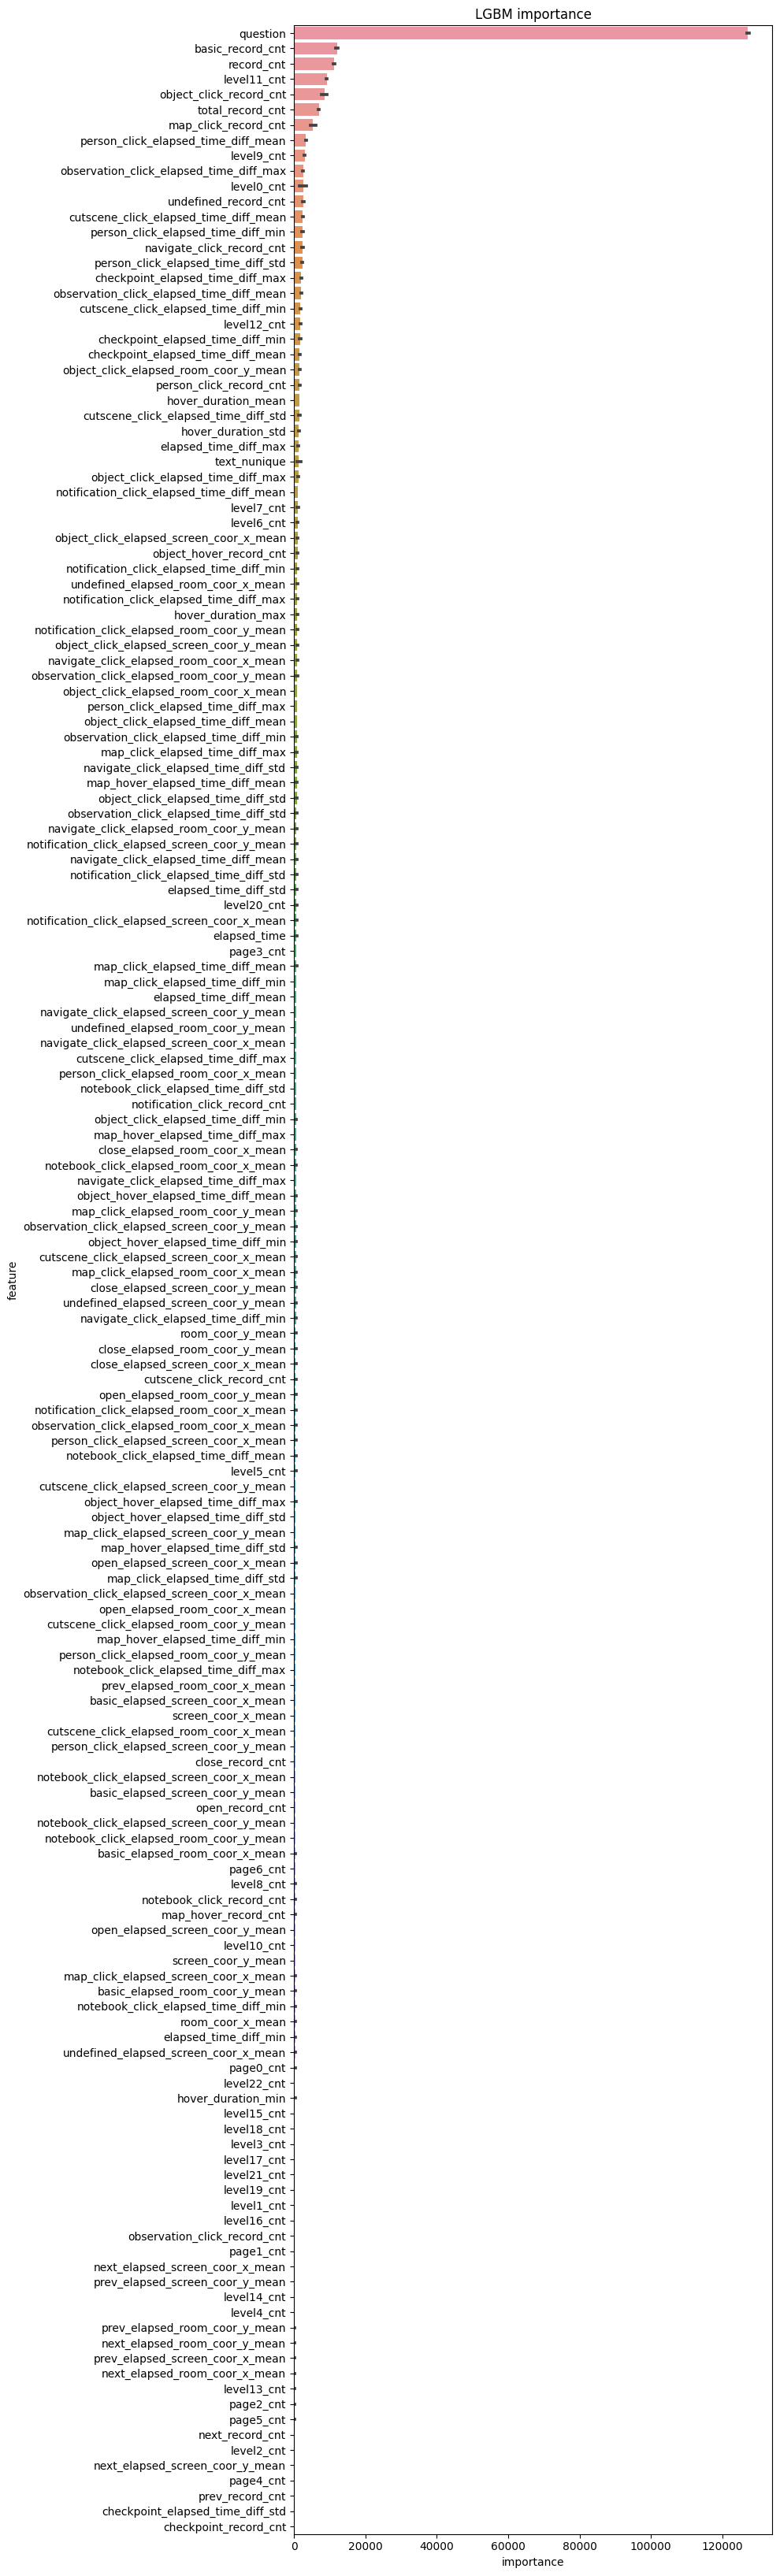

In [14]:
if cfg.mode == "local_cv":
    run_train()
inference(cfg.mode)